In [138]:
import glob
from datetime import datetime
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats, signal
from scipy.stats import mode
from scipy.fft import fft
from sklearn.ensemble import RandomForestClassifier as RFC, ExtraTreesClassifier as ETC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler


import lightgbm as lgb
import xgboost as xgb

from tqdm import tqdm, trange

# Generic functions (usable for all test cases)

## Core functions (Change path here)

In [106]:
def segmentation(df, overlap_rate, time_window):
    seg_data = []
    #convert overlap rate to step for sliding window
    overlap = int((1 - overlap_rate)*time_window)
    # interpolate
    df = df.interpolate().ffill().fillna(0)
    for i in range(0, len(df)-time_window+1, overlap):
        seg_data.append(df.loc[i:i+time_window-1, :].copy().reset_index(drop=True))
    return seg_data


def rename_columns(df):
    df.columns = [
        "FH_X", "FH_Y", "FH_Z",     #1
        "TH_X", "TH_Y", "TH_Z",     #2
        "RH_X", "RH_Y", "RH_Z",     #3
        "RS_X", "RS_Y", "RS_Z",     #4
        "RO_X", "RO_Y", "RO_Z",     #5
        "RE_X", "RE_Y", "RE_Z",     #6
        "RW_X", "RW_Y", "RW_Z",     #7
        "LS_X", "LS_Y", "LS_Z",     #8
        "LE_X", "LE_Y", "LE_Z",     #9
        "LW_X", "LW_Y", "LW_Z",     #10
        "RA_X", "RA_Y", "RA_Z",     #11
        "LA_X", "LA_Y", "LA_Z",     #12
        "VS_X", "VS_Y", "VS_Z",     #13
        "subject_id", "activity",   # Other columns
    ]
    return df


def dataloader(overlap, window_size, verbose=True):
    if verbose:
        print("loading the data...", end="\t")
    data_list = []
    file_lengths = {1: [], 2: [], 3: []}
    ##### CHANGE PATH ######
    files = tqdm(glob.glob("../TrainData/*/*/*.csv")) if verbose else glob.glob("../TrainData/*/*/*.csv")
    ##### ##### ##### ######
    for file in files:
        tempdf = pd.read_csv(file)
        tempdf = rename_columns(tempdf)
        segmented_data = segmentation(tempdf, overlap, window_size)
        if len(segmented_data)>0:
            person = segmented_data[0].reset_index(drop=True).loc[0, "subject_id"]
            file_lengths[person].append(len(segmented_data))   
        data_list.extend(segmented_data)
    return data_list, file_lengths


def feature_extractor(data_list, verbose=True):
    if verbose:
        print(f"extracting the features...", end="  ")
    X, y = {1:[], 2:[], 3:[]}, {1:[], 2:[], 3:[]}
    num_range = trange(0,len(data_list)) if verbose else range(0,len(data_list))
    for j in num_range:
        #extract only xyz columns
        person = data_list[j].loc[0, "subject_id"]
        x_data = data_list[j].drop(columns=["subject_id","activity"])
        X[person].append(get_features(x_data))
        y[person].append(data_list[j].reset_index(drop=True).loc[0, "activity"])
    return X, y


def majority_voting(predictions, file_lengths):
    filtered_predictions = []
    index = 0
    for length in file_lengths:
        file_pred = predictions[index:index+length]
        modes = mode(file_pred)
        majority_choice = modes.mode[0]
        filtered_predictions.extend([majority_choice]*length)
        index += length
    return filtered_predictions

In [139]:
def get_processed_dataset(overlap_rate, window_size, verbose=True):
    data_list, file_lengths = dataloader(overlap_rate, window_size, verbose=verbose)
    stream_list = []
    for df in data_list:
        stream_list.append(get_streams(df))
    X, y = feature_extractor(stream_list, verbose=verbose)
    return X, y, file_lengths


def model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True):
    scores = []
    num_range = trange(n_repeats) if verbose else range(n_repeats)
    for _ in num_range:
        for p1, p2, p3 in [(1,2,3), (2,3,1), (3,1,2)]:
            X_test, y_test = X[p1], y[p1]
            X_train = X[p2] + X[p3]
            y_train = y[p2] + y[p3]
            # print(f"training model for person {p1}/3...", end="\t")
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            if voting:
                filtered_pred = majority_voting(pred, file_lengths[p1])
                scores.append(accuracy_score(y_test, filtered_pred))
            else:
                scores.append(accuracy_score(y_test, pred))
    if verbose:
        print(f"Mean Score: {np.mean(scores)}")
        print(f"Std Score: {np.std(scores)}")
        print(f"Min Score: {np.min(scores)}")
        print(f"Max Score: {np.max(scores)}")
    return scores


def scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True):
    scores = []
    num_range = trange(n_repeats) if verbose else range(n_repeats)
    for _ in num_range:
        for p1, p2, p3 in [(1,2,3), (2,3,1), (3,1,2)]:
            X_test, y_test = X[p1], y[p1]
            X_train = X[p2] + X[p3]
            y_train = y[p2] + y[p3]
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.fit_transform(X_test)
            # print(f"training model for person {p1}/3...", end="\t")
            model.fit(X_train_scaled, y_train)
            pred = model.predict(X_test_scaled)
            if voting:
                filtered_pred = majority_voting(pred, file_lengths[p1])
                scores.append(accuracy_score(y_test, filtered_pred))
            else:
                scores.append(accuracy_score(y_test, pred))
    if verbose:
        print(f"Mean Score: {np.mean(scores)}")
        print(f"Std Score: {np.std(scores)}")
        print(f"Min Score: {np.min(scores)}")
        print(f"Max Score: {np.max(scores)}")
    return scores

In [108]:
def LOOCV_train_evaluate(model, overlap_rate, window_size, voting=True, n_repeats=1, verbose=True):
    scores = []
    data_list, file_lengths = dataloader(overlap_rate, window_size, verbose=verbose)
    stream_list = []
    for df in data_list:
        stream_list.append(get_streams(df))
    X, y = feature_extractor(stream_list, verbose=verbose)
    num_range = trange(n_repeats) if verbose else range(n_repeats)
    for _ in num_range:
        for p1, p2, p3 in [(1,2,3), (2,3,1), (3,1,2)]:
            X_test, y_test = X[p1], y[p1]
            X_train = X[p2] + X[p3]
            y_train = y[p2] + y[p3]
            # print(f"training model for person {p1}/3...", end="\t")
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            if voting:
                filtered_pred = majority_voting(pred, file_lengths[p1])
                scores.append(accuracy_score(y_test, filtered_pred))
            else:
                scores.append(accuracy_score(y_test, pred))
    if verbose:
        print(f"\nMean Score: {np.mean(scores)}")
    return scores


def GridSearch(parameters, csvpath = "..", filename="gridCV_results", n_repeats=7, verbose=False, progress=True):
    score_df = pd.DataFrame({"model": [], "window_size": [], "overlap_rate": [], "n_repeats":[], 
                            "avg_score": [], "std_score": [], "scores":[]})
    models, window_sizes, overlap_rates = parameters["model"], parameters["window_size"], parameters["overlap_rate"]
    combinations = [(i,j,k) for i in models for j in window_sizes for k in overlap_rates]
    if progress:
        combinations = tqdm(combinations)
    for combination in combinations:
        model, window_size, overlap_rate = combination
        scores = LOOCV_train_evaluate(model, overlap_rate, window_size, n_repeats=n_repeats, verbose=verbose)
        score_df = score_df.append({"model": model.__str__(), "window_size": window_size, 
                    "overlap_rate": overlap_rate, "n_repeats": n_repeats, "avg_score": np.mean(scores),
                    "std_score": np.array(scores).std(),"scores": scores}, ignore_index=True)
    savepath = f"{csvpath}/{filename}_{str(datetime.now())[:-7]}.csv".replace(":", ".")
    score_df.to_csv(savepath, index=False)
    print(f"result exported to: {savepath}")


## Stream Extractors

In [109]:
def get_speed_acc(x_data):
    x_data = x_data.drop(columns=["activity", "subject_id"])
    speed = x_data.diff().fillna(0)
    acc = speed.diff().fillna(0)
    speed.columns = [f"{col}_speed" for col in speed.columns]
    acc.columns = [f"{col}_acc" for col in acc.columns]
    return speed, acc

def get_speed_acc_jerk(x_data):
    x_data = x_data.drop(columns=["activity", "subject_id"])
    speed = x_data.diff().fillna(0)
    acc = speed.diff().fillna(0)
    jerk = acc.diff().fillna(0)
    speed.columns = [f"{col}_speed" for col in speed.columns]
    acc.columns = [f"{col}_acc" for col in acc.columns]
    jerk.columns = [f"{col}_jerk" for col in acc.columns]
    return speed, acc, jerk

In [110]:
def joint_distance(x_data, joint1, joint2):
    """
    returns the distance between two joints. 
    """
    x1, y1, z1 = x_data[f"{joint1}_X"], x_data[f"{joint1}_Y"], x_data[f"{joint1}_Z"]
    x2, y2, z2 = x_data[f"{joint2}_X"], x_data[f"{joint2}_Y"], x_data[f"{joint2}_Z"]
    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    return distance

def get_all_joint_distances(x_data):
    """
    calculates all the necessary joint distances from the `x_data`, 
    adds columns to it and returns the modified `x_data`.
    the two joints should not be essentially consecutive, 
    because the distance between two consecutive joints is always constant.
    For example, distance between left_wrist and left_elbow is always constant.
    """
    # joints
    # Front head        ->  left shoulder       (1->8)
    x_data["dist_FH_LS"] = joint_distance(x_data, "FH", "LS")
    # Front head        ->  right shoulder      (1->4)
    x_data["dist_FH_RS"] = joint_distance(x_data, "FH", "RS")
    # left shoulder     ->  left wrist          (8->10)
    x_data["dist_LS_LW"] = joint_distance(x_data, "LS", "LW")
    # right shoulder    ->  right wrist         (4->7)
    x_data["dist_RS_RW"] = joint_distance(x_data, "RS", "RW")
    # v sacral          ->  left elbow          (13->9)
    x_data["dist_VS_LE"] = joint_distance(x_data, "VS", "LE")
    # v sacral          ->  right elbow         (13->6)
    x_data["dist_VS_RE"] = joint_distance(x_data, "VS", "RE")
    # v sacral          ->  left wrist          (13->10)
    x_data["dist_VS_LW"] = joint_distance(x_data, "VS", "LW")
    # v sacral          ->  right wrist         (13->7)
    x_data["dist_VS_RW"] = joint_distance(x_data, "VS", "RW")
    # v sacral          ->  rear head           (13->3)
    x_data["dist_VS_RH"] = joint_distance(x_data, "VS", "RH")
    # v sacral          ->  top head            (13->2)
    x_data["dist_VS_TH"] = joint_distance(x_data, "VS", "TH")
    # left wrist        ->  right wrist         (10->7)
    x_data["dist_LW_RW"] = joint_distance(x_data, "LW", "RW")
    # left asis         ->  left wrist          (12->10)
    x_data["dist_LA_LW"] = joint_distance(x_data, "LA", "LW")
    # right asis        ->  right wrist         (11->7)
    x_data["dist_RA_RW"] = joint_distance(x_data, "RA", "RW")
    # left wrist        ->  top head            (10->2)
    x_data["dist_LW_TH"] = joint_distance(x_data, "LW", "TH")
    # right wrist       ->  top head            (7->2)
    x_data["dist_RW_TH"] = joint_distance(x_data, "RW", "TH")
    # top head          ->  left asis           (2->12)
    x_data["dist_TH_LA"] = joint_distance(x_data, "TH", "LA")
    return x_data



In [111]:
def joint_angle(x_data, joint1, joint2, joint3):
    x1, y1, z1 = x_data[f"{joint1}_X"], x_data[f"{joint1}_Y"], x_data[f"{joint1}_Z"]
    x2, y2, z2 = x_data[f"{joint2}_X"], x_data[f"{joint2}_Y"], x_data[f"{joint2}_Z"]
    x3, y3, z3 = x_data[f"{joint3}_X"], x_data[f"{joint3}_Y"], x_data[f"{joint3}_Z"]
    v1 = np.array([x2-x1, y2-y1, z2-z1]).T
    v2 = np.array([x3-x2, y3-y2, z3-z2]).T
    v1_unit = v1/np.expand_dims(np.linalg.norm(v1, axis=1), axis=1)
    v2_unit = v2/np.expand_dims(np.linalg.norm(v2, axis=1), axis=1)
    angle = np.arccos(np.sum(v1_unit*v2_unit, axis=1)) # dot multiplication
    return angle

def get_all_joint_angles(x_data):
    # joints
    # left shoulder     ->  left elbow      ->  left wrist      (8->9->10)
    x_data["angle_LS_LE_LW"] = joint_angle(x_data, "LS", "LE", "LW")
    # right shoulder    ->  right elbow     ->  right wrist     (4->6->7)
    x_data["angle_RS_RE_RW"] = joint_angle(x_data, "RS", "RE", "RW")
    # right shoulder    ->  left shoulder   ->  front head      (4->8->1)
    x_data["angle_RS_LS_FH"] = joint_angle(x_data, "RS", "LS", "FH")
    # right shoulder    ->  left shoulder   ->  left elbow      (4->8->9)
    x_data["angle_RS_LS_LE"] = joint_angle(x_data, "RS", "LS", "LE")
    # left shoulder     ->  right shoulder  ->  right elbow     (8->4->6)
    x_data["angle_LS_RS_RE"] = joint_angle(x_data, "LS", "RS", "RE")
    # v sacral          ->  right offset    ->  rear head       (13->5->3)
    x_data["angle_VS_RO_RH"] = joint_angle(x_data, "VS", "RO", "RH")
    # vsacral           ->  top head        ->  front head      (13->2->1)
    x_data["angle_VS_TH_FH"] = joint_angle(x_data, "VS", "TH", "FH")
    # v sacral          ->  left shoulder   ->  left elbow      (13->8->9)
    x_data["angle_VS_LS_LE"] = joint_angle(x_data, "VS", "LS", "LE")
    # v sacral          ->  right shoulder  ->  right elbow     (13->4->6)
    x_data["angle_VS_RS_RE"] = joint_angle(x_data, "VS", "RS", "RE")
    # left asis         ->  left shoulder   ->  left elbow      (12->8->9)
    x_data["angle_LA_LS_LE"] = joint_angle(x_data, "LA", "LS", "LE")
    # right asis        -> right shoulder   ->  right elbow     (11->4->6)
    x_data["angle_RA_RS_RE"] = joint_angle(x_data, "RA", "RS", "RE")
    return x_data

In [112]:
def get_all_joint_angles_red(x_data):
    # joints
    x_data["angle_LS_LE_LW"] = joint_angle(x_data, "LS", "LE", "LW")
    x_data["angle_RS_RE_RW"] = joint_angle(x_data, "RS", "RE", "RW")
    x_data["angle_RS_LS_LE"] = joint_angle(x_data, "RS", "LS", "LE")
    x_data["angle_LS_RS_RE"] = joint_angle(x_data, "LS", "RS", "RE")
    x_data["angle_VS_RO_RH"] = joint_angle(x_data, "VS", "RO", "RH")
    return x_data

In [113]:
def get_all_joint_angles_diff_red(x_data):
    # joints
    x_data["ang_dif_LS_LE_LW"] = np.nan_to_num(np.append(np.diff(joint_angle(x_data, "LS", "LE", "LW")), 0)).tolist()
    x_data["ang_dif_RS_RE_RW"] = np.nan_to_num(np.append(np.diff(joint_angle(x_data, "RS", "RE", "RW")), 0)).tolist()
    x_data["ang_dif_RS_LS_LE"] = np.nan_to_num(np.append(np.diff(joint_angle(x_data, "RS", "LS", "LE")), 0)).tolist()
    x_data["ang_dif_LS_RS_RE"] = np.nan_to_num(np.append(np.diff(joint_angle(x_data, "LS", "RS", "RE")), 0)).tolist()
    x_data["ang_dif_VS_RO_RH"] = np.nan_to_num(np.append(np.diff(joint_angle(x_data, "VS", "RO", "RH")), 0)).tolist()
    return x_data

In [198]:
def plane_angles(x_data, joint1, joint2):
    x1, y1, z1 = x_data[f"{joint1}_X"], x_data[f"{joint1}_Y"], x_data[f"{joint1}_Z"]
    x2, y2, z2 = x_data[f"{joint2}_X"], x_data[f"{joint2}_Y"], x_data[f"{joint2}_Z"]
    v = np.array([x2-x1, y2-y1, z2-z1]).T
    vx = np.array([1, 0, 0])
    vy = np.array([0, 1, 0])
    vz = np.array([0, 0, 1])
    v_unit = v/np.expand_dims(np.linalg.norm(v, axis=1), axis=1)
    angle_x = np.arccos(np.sum(v_unit*vx, axis=1)) 
    angle_y = np.arccos(np.sum(v_unit*vy, axis=1)) 
    angle_z = np.arccos(np.sum(v_unit*vz, axis=1)) 
    return angle_x, angle_y, angle_z

def get_all_angles_with_plane(x_data):
    # joints
    # arm angles: left shoulder     ->  left elbow 
    x_data["angle_x_LS_LE"], x_data["angle_y_LS_LE"], x_data["angle_z_LS_LE"] = plane_angles(x_data, "LS", "LE")
    # forearm angles: left elbow    ->  left  wrist
    x_data["angle_x_LE_LW"], x_data["angle_y_LE_LW"], x_data["angle_z_LE_LW"] = plane_angles(x_data, "LE", "LW")
    # arm angles: right shoulder    ->  right elbow 
    x_data["angle_x_RS_RE"], x_data["angle_y_RS_RE"], x_data["angle_z_RS_RE"] = plane_angles(x_data, "RS", "RE")
    # forearm angles: right elbow   ->  right  wrist
    x_data["angle_x_RE_RW"], x_data["angle_y_RE_RW"], x_data["angle_z_RE_RW"] = plane_angles(x_data, "RE", "RW")
    # backbone angles: v sacral     ->  rear head
    # x_data["angle_x_VS_RH"], x_data["angle_y_VS_RH"], x_data["angle_z_VS_RH"] = plane_angles(x_data, "VS", "RH")
    return x_data

# Pre-processed functions (add/remove streams/features here)

In [115]:
def current_best():
    def get_streams(x_data):
        speed, acc = get_speed_acc(x_data)
        x_data = pd.concat([x_data, speed, acc], axis=1)
        # speed, acc, jerk = get_speed_acc_jerk(x_data)
        # x_data = pd.concat([x_data, speed, acc, jerk], axis=1)
        x_data = get_all_joint_distances(x_data)
        # x_data = get_all_joint_angles(x_data)
        # x_data = get_all_angles_with_plane(x_data)
        return x_data

    def get_features(x_data):
        features = []
        cols = x_data.columns.tolist()
        #Calculate features (STD, Average, Max, Min, Median, Variance) for each data columns X Y Z 
        for k in cols:
            features.append(x_data[k].std(ddof=0))
            # features.append(np.average(x_data[k]))
            features.append(np.max(x_data[k]))
            features.append(np.min(x_data[k]))
            features.append(np.median(x_data[k]))        
            # features.append(np.var(x_data[k]))
            # fd = np.abs(fft(np.array(x_data[k])))**2
            # features.append(stats.skew(fd))
            # features.append(stats.kurtosis(fd))
        return features
    joint_names = ['FH', 'TH', 'RH', 'RS', 'RO', 'RE', 'RW', 'LS', 'LE', 'LW', 'RA', 'LA', 'VS']
    pos_cols = [i+j for i in joint_names for j in ["_X", "_Y", "_Z"]]
    speed_cols = [f"{col}_speed" for col in pos_cols]
    acc_cols = [f"{col}_acc" for col in pos_cols]
    distance_cols = ['dist_FH_LS', 'dist_FH_RS', 'dist_LS_LW', 'dist_RS_RW', 'dist_VS_LE', 'dist_VS_RE', 
        'dist_VS_LW', 'dist_VS_RW','dist_VS_RH', 'dist_VS_TH', 'dist_LW_RW', 'dist_LA_LW', 'dist_RA_RW', 
        'dist_LW_TH', 'dist_RW_TH', 'dist_TH_LA']
    colnames = pos_cols + speed_cols + acc_cols + distance_cols
    return get_streams, get_features, colnames

In [116]:
def fd_features_remove_acc():
    def get_streams(x_data):
        speed, acc = get_speed_acc(x_data)
        x_data = pd.concat([x_data, speed], axis=1)
        # speed, acc, jerk = get_speed_acc_jerk(x_data)
        # x_data = pd.concat([x_data, speed, acc, jerk], axis=1)
        x_data = get_all_joint_distances(x_data)
        # x_data = get_all_joint_angles(x_data)
        # x_data = get_all_angles_with_plane(x_data)
        return x_data

    def get_features(x_data):
        features = []
        cols = x_data.columns.tolist()
        #Calculate features (STD, Average, Max, Min, Median, Variance) for each data columns X Y Z 
        for k in cols:
            features.append(x_data[k].std(ddof=0))
            # features.append(np.average(x_data[k]))
            features.append(np.max(x_data[k]))
            features.append(np.min(x_data[k]))
            features.append(np.median(x_data[k]))        
            # features.append(np.var(x_data[k]))
            fd = np.abs(fft(np.array(x_data[k])))**2
            # features.append(stats.skew(fd))
            # features.append(stats.kurtosis(fd))
            features.append(np.median(fd))
            features.append(np.min(fd))
            features.append(np.max(fd))
        return features
    joint_names = ['FH', 'TH', 'RH', 'RS', 'RO', 'RE', 'RW', 'LS', 'LE', 'LW', 'RA', 'LA', 'VS']
    pos_cols = [i+j for i in joint_names for j in ["_X", "_Y", "_Z"]]
    speed_cols = [f"{col}_speed" for col in pos_cols]
    # acc_cols = [f"{col}_acc" for col in pos_cols]
    distance_cols = ['dist_FH_LS', 'dist_FH_RS', 'dist_LS_LW', 'dist_RS_RW', 'dist_VS_LE', 'dist_VS_RE', 
        'dist_VS_LW', 'dist_VS_RW','dist_VS_RH', 'dist_VS_TH', 'dist_LW_RW', 'dist_LA_LW', 'dist_RA_RW', 
        'dist_LW_TH', 'dist_RW_TH', 'dist_TH_LA']
    colnames = pos_cols + speed_cols + distance_cols
    return get_streams, get_features, colnames

In [117]:
def remove_acc():
    def get_streams(x_data):
        speed, acc = get_speed_acc(x_data)
        x_data = pd.concat([x_data, speed], axis=1)
        x_data = get_all_joint_distances(x_data)
        return x_data

    def get_features(x_data):
        features = []
        cols = x_data.columns.tolist()
        #Calculate features (STD, Average, Max, Min, Median, Variance) for each data columns X Y Z 
        for k in cols:
            features.append(x_data[k].std(ddof=0))
            # features.append(np.average(x_data[k]))
            features.append(np.max(x_data[k]))
            features.append(np.min(x_data[k]))
            features.append(np.median(x_data[k]))        
        return features
    joint_names = ['FH', 'TH', 'RH', 'RS', 'RO', 'RE', 'RW', 'LS', 'LE', 'LW', 'RA', 'LA', 'VS']
    pos_cols = [i+j for i in joint_names for j in ["_X", "_Y", "_Z"]]
    speed_cols = [f"{col}_speed" for col in pos_cols]
    # acc_cols = [f"{col}_acc" for col in pos_cols]
    distance_cols = ['dist_FH_LS', 'dist_FH_RS', 'dist_LS_LW', 'dist_RS_RW', 'dist_VS_LE', 'dist_VS_RE', 
        'dist_VS_LW', 'dist_VS_RW','dist_VS_RH', 'dist_VS_TH', 'dist_LW_RW', 'dist_LA_LW', 'dist_RA_RW', 
        'dist_LW_TH', 'dist_RW_TH', 'dist_TH_LA']
    colnames = pos_cols + speed_cols + distance_cols
    return get_streams, get_features, colnames

In [118]:
def angle_dif_red_remove_acc():
    def get_streams(x_data):
        speed, acc = get_speed_acc(x_data)
        x_data = pd.concat([x_data, speed], axis=1)
        x_data = get_all_joint_distances(x_data)
        x_data = get_all_joint_angles_diff_red(x_data)
        return x_data

    def get_features(x_data):
        features = []
        cols = x_data.columns.tolist()
        #Calculate features (STD, Average, Max, Min, Median, Variance) for each data columns X Y Z 
        for k in cols:
            features.append(x_data[k].std(ddof=0))
            # features.append(np.average(x_data[k]))
            features.append(np.max(x_data[k]))
            features.append(np.min(x_data[k]))
            features.append(np.median(x_data[k]))        
        return features
    joint_names = ['FH', 'TH', 'RH', 'RS', 'RO', 'RE', 'RW', 'LS', 'LE', 'LW', 'RA', 'LA', 'VS']
    pos_cols = [i+j for i in joint_names for j in ["_X", "_Y", "_Z"]]
    speed_cols = [f"{col}_speed" for col in pos_cols]
    # acc_cols = [f"{col}_acc" for col in pos_cols]
    distance_cols = ['dist_FH_LS', 'dist_FH_RS', 'dist_LS_LW', 'dist_RS_RW', 'dist_VS_LE', 'dist_VS_RE', 
        'dist_VS_LW', 'dist_VS_RW','dist_VS_RH', 'dist_VS_TH', 'dist_LW_RW', 'dist_LA_LW', 'dist_RA_RW', 
        'dist_LW_TH', 'dist_RW_TH', 'dist_TH_LA']
    angle_dif_cols = ["LSLELW", "RSRERW", "RSLSLE", "LSRSRE", "VSRORH"]
    colnames = pos_cols + speed_cols + distance_cols + angle_dif_cols
    return get_streams, get_features, colnames

In [119]:
def angle_red_remove_acc():
    def get_streams(x_data):
        speed, acc = get_speed_acc(x_data)
        x_data = pd.concat([x_data, speed], axis=1)
        x_data = get_all_joint_distances(x_data)
        x_data = get_all_joint_angles_diff_red(x_data)
        return x_data

    def get_features(x_data):
        features = []
        cols = x_data.columns.tolist()
        #Calculate features (STD, Average, Max, Min, Median, Variance) for each data columns X Y Z 
        for k in cols:
            features.append(x_data[k].std(ddof=0))
            # features.append(np.average(x_data[k]))
            features.append(np.max(x_data[k]))
            features.append(np.min(x_data[k]))
            features.append(np.median(x_data[k]))        
        return features
    joint_names = ['FH', 'TH', 'RH', 'RS', 'RO', 'RE', 'RW', 'LS', 'LE', 'LW', 'RA', 'LA', 'VS']
    pos_cols = [i+j for i in joint_names for j in ["_X", "_Y", "_Z"]]
    speed_cols = [f"{col}_speed" for col in pos_cols]
    # acc_cols = [f"{col}_acc" for col in pos_cols]
    distance_cols = ['dist_FH_LS', 'dist_FH_RS', 'dist_LS_LW', 'dist_RS_RW', 'dist_VS_LE', 'dist_VS_RE', 
        'dist_VS_LW', 'dist_VS_RW','dist_VS_RH', 'dist_VS_TH', 'dist_LW_RW', 'dist_LA_LW', 'dist_RA_RW', 
        'dist_LW_TH', 'dist_RW_TH', 'dist_TH_LA']
    angle_dif_cols = ["LSLELW", "RSRERW", "RSLSLE", "LSRSRE", "VSRORH"]
    colnames = pos_cols + speed_cols + distance_cols + angle_dif_cols
    return get_streams, get_features, colnames

In [199]:
def angle_red_plane_remove_acc():
    def get_streams(x_data):
        speed, acc = get_speed_acc(x_data)
        x_data = pd.concat([x_data, speed], axis=1)
        x_data = get_all_joint_distances(x_data)
        x_data = get_all_joint_angles_diff_red(x_data)
        x_data = get_all_angles_with_plane(x_data)
        return x_data

    def get_features(x_data):
        features = []
        cols = x_data.columns.tolist()
        #Calculate features (STD, Average, Max, Min, Median, Variance) for each data columns X Y Z 
        for k in cols:
            features.append(x_data[k].std(ddof=0))
            # features.append(np.average(x_data[k]))
            features.append(np.max(x_data[k]))
            features.append(np.min(x_data[k]))
            features.append(np.median(x_data[k]))        
        return features
    joint_names = ['FH', 'TH', 'RH', 'RS', 'RO', 'RE', 'RW', 'LS', 'LE', 'LW', 'RA', 'LA', 'VS']
    pos_cols = [i+j for i in joint_names for j in ["_X", "_Y", "_Z"]]
    speed_cols = [f"{col}_speed" for col in pos_cols]
    # acc_cols = [f"{col}_acc" for col in pos_cols]
    distance_cols = ['dist_FH_LS', 'dist_FH_RS', 'dist_LS_LW', 'dist_RS_RW', 'dist_VS_LE', 'dist_VS_RE', 
        'dist_VS_LW', 'dist_VS_RW','dist_VS_RH', 'dist_VS_TH', 'dist_LW_RW', 'dist_LA_LW', 'dist_RA_RW', 
        'dist_LW_TH', 'dist_RW_TH', 'dist_TH_LA']
    angle_dif_cols = ["LSLELW", "RSRERW", "RSLSLE", "LSRSRE", "VSRORH"]
    colnames = pos_cols + speed_cols + distance_cols + angle_dif_cols
    return get_streams, get_features, colnames

# Random Forest

## best model

In [13]:
get_streams, get_features, colnames = current_best()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)

loading the data...	

100%|██████████| 151/151 [00:16<00:00,  9.00it/s]


extracting the features...  

100%|██████████| 736/736 [01:18<00:00,  9.43it/s]


In [40]:
model = RFC(600, criterion="entropy", n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [02:13<00:00, 13.34s/it]

Mean Score: 0.6996705457295657
Std Score: 0.04504596375149795
Min Score: 0.5903083700440529
Max Score: 0.759075907590759


In [43]:
model = RFC(1200, criterion="gini", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [02:05<00:00, 12.56s/it]

Mean Score: 0.715566886015833
Std Score: 0.03187665295686838
Min Score: 0.6343612334801763
Max Score: 0.7961165048543689


In [45]:
model = RFC(1200, criterion="gini", min_samples_split=6, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [02:21<00:00, 14.17s/it]

Mean Score: 0.7183364356708543
Std Score: 0.030369686801219008
Min Score: 0.6563876651982379
Max Score: 0.7572815533980582


## without acc 4000

In [187]:
get_streams, get_features, colnames = remove_acc()
overlap_rate, window_size = 0.8, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)

loading the data...	

100%|██████████| 151/151 [00:16<00:00,  9.20it/s]


extracting the features...  

100%|██████████| 512/512 [00:51<00:00, 10.02it/s]


In [188]:
model = RFC(2500, criterion="gini", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [04:10<00:00, 25.07s/it]

Mean Score: 0.7651586670998164
Std Score: 0.018800900564073617
Min Score: 0.7293233082706767
Max Score: 0.7973856209150327


## red angle remove acc 4000

In [190]:
get_streams, get_features, colnames = angle_red_remove_acc()
overlap_rate, window_size = 0.8, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)

loading the data...	

100%|██████████| 151/151 [00:16<00:00,  9.20it/s]


extracting the features...  

100%|██████████| 512/512 [00:53<00:00,  9.53it/s]


In [195]:
model = RFC(3000, criterion="gini", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [04:49<00:00, 28.98s/it]

Mean Score: 0.7681095705890907
Std Score: 0.0192402908854686
Min Score: 0.7218045112781954
Max Score: 0.8097345132743363


## red angle plane rem acc 4000 0.8

In [201]:
get_streams, get_features, colnames = angle_red_plane_remove_acc()
overlap_rate, window_size = 0.8, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)

loading the data...	

100%|██████████| 151/151 [00:17<00:00,  8.41it/s]


extracting the features...  

100%|██████████| 512/512 [00:59<00:00,  8.56it/s]


In [202]:
model = RFC(3000, criterion="gini", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [04:49<00:00, 28.96s/it]

Mean Score: 0.7602451672590581
Std Score: 0.027535270208648363
Min Score: 0.7035398230088495
Max Score: 0.8104575163398693


In [203]:
model = RFC(2500, criterion="gini", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [04:13<00:00, 25.38s/it]

Mean Score: 0.7633096927639244
Std Score: 0.032638468107656846
Min Score: 0.6858407079646017
Max Score: 0.8169934640522876


# Extra trees scaled

## Best model

In [143]:
get_streams, get_features, colnames = current_best()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:12<00:00, 12.20it/s]


extracting the features...  

100%|██████████| 736/736 [01:43<00:00,  7.14it/s]


In [147]:
model = ETC(1800, criterion="gini", max_depth=12, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [02:21<00:00, 14.16s/it]

Mean Score: 0.7222349872812865
Std Score: 0.02946121690582047
Min Score: 0.6747572815533981
Max Score: 0.775330396475771


In [148]:
model = ETC(1200, criterion="gini", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:34<00:00,  9.41s/it]

Mean Score: 0.7216678173099377
Std Score: 0.03830982793657475
Min Score: 0.6553398058252428
Max Score: 0.8105726872246696


In [ ]:
model = ETC(1800, criterion="gini", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

## remove acc

In [150]:
get_streams, get_features, colnames = remove_acc()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:18<00:00,  8.17it/s]


extracting the features...  

100%|██████████| 736/736 [01:07<00:00, 10.84it/s]


In [151]:
model = ETC(1200, criterion="gini", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:31<00:00,  9.17s/it]

Mean Score: 0.714327094357783
Std Score: 0.05925819123792138
Min Score: 0.6116504854368932
Max Score: 0.8184818481848185


In [153]:
model = ETC(1200, criterion="entropy", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:35<00:00,  9.59s/it]

Mean Score: 0.7151073344792245
Std Score: 0.04367069179714772
Min Score: 0.6310679611650486
Max Score: 0.7953795379537953


## Remove acc 4000

In [216]:
get_streams, get_features, colnames = remove_acc()
overlap_rate, window_size = 0.75, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:12<00:00, 11.65it/s]


extracting the features...  

100%|██████████| 414/414 [00:37<00:00, 11.04it/s]


In [220]:
model = ETC(2400, criterion="entropy", max_depth=12, min_samples_split=4, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [02:22<00:00, 14.28s/it]

Mean Score: 0.7586238257931741
Std Score: 0.019685710936705278
Min Score: 0.7265625
Max Score: 0.7932960893854749


## rem acc 4000 angle

In [172]:
get_streams, get_features, colnames = angle_red_remove_acc()
overlap_rate, window_size = 0.75, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:17<00:00,  8.87it/s]


extracting the features...  

100%|██████████| 414/414 [00:39<00:00, 10.49it/s]


In [176]:
model = ETC(2500, criterion="entropy", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [02:42<00:00, 16.23s/it]

Mean Score: 0.747013237156059
Std Score: 0.011785752453283359
Min Score: 0.71875
Max Score: 0.776536312849162


In [179]:
model = ETC(1800, criterion="gini", n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [02:36<00:00, 15.61s/it]

Mean Score: 0.7527635330191963
Std Score: 0.01854210964762528
Min Score: 0.7265625
Max Score: 0.796875


## 4000 0.8 angles rem acc

In [204]:
get_streams, get_features, colnames = angle_red_remove_acc()
overlap_rate, window_size = 0.8, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)

loading the data...	

100%|██████████| 151/151 [00:17<00:00,  8.62it/s]


extracting the features...  

100%|██████████| 512/512 [00:47<00:00, 10.79it/s]


In [205]:
model = ETC(1200, criterion="entropy", max_depth=12, min_samples_split=4, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:30<00:00,  9.06s/it]

Mean Score: 0.739185323769833
Std Score: 0.02887023985396589
Min Score: 0.6616541353383458
Max Score: 0.7908496732026143


In [197]:
model = ETC(1800, criterion="entropy", max_depth=12, min_samples_split=4, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [02:04<00:00, 12.47s/it]

Mean Score: 0.7440033727096387
Std Score: 0.025397728836219644
Min Score: 0.6766917293233082
Max Score: 0.7920353982300885


In [206]:
model = ETC(3000, criterion="entropy", max_depth=12, min_samples_split=4, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [03:21<00:00, 20.18s/it]

Mean Score: 0.7459716951004385
Std Score: 0.020969127052732132
Min Score: 0.6814159292035398
Max Score: 0.7777777777777778


## 0.8 4000 rm acc

In [222]:
get_streams, get_features, colnames = remove_acc()
overlap_rate, window_size = 0.8, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)

loading the data...	

100%|██████████| 151/151 [00:17<00:00,  8.47it/s]


extracting the features...  

100%|██████████| 512/512 [00:40<00:00, 12.77it/s]


In [209]:
model = ETC(1200, criterion="entropy", max_depth=12, min_samples_split=4, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:21<00:00,  8.20s/it]

Mean Score: 0.7599630619727061
Std Score: 0.02370172867833763
Min Score: 0.706766917293233
Max Score: 0.7908496732026143


In [223]:
model = ETC(1800, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:56<00:00, 11.64s/it]

Mean Score: 0.7501498337781525
Std Score: 0.03126528864376816
Min Score: 0.6616541353383458
Max Score: 0.8053097345132744


In [224]:
model = ETC(3000, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [03:11<00:00, 19.18s/it]

Mean Score: 0.7538700415217582
Std Score: 0.032389618106118324
Min Score: 0.6992481203007519
Max Score: 0.8053097345132744


# Extra Trees

## Best features

In [22]:
get_streams, get_features, colnames = current_best()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:15<00:00,  9.80it/s]


extracting the features...  

100%|██████████| 736/736 [01:27<00:00,  8.40it/s]


In [60]:
model = ETC(1800, criterion="gini", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [02:20<00:00, 14.03s/it]

Mean Score: 0.7363534084472131
Std Score: 0.034126056701583855
Min Score: 0.6651982378854625
Max Score: 0.8203883495145631


In [72]:
model = ETC(1800, criterion="gini", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [02:11<00:00, 13.16s/it]

Mean Score: 0.7338456671893613
Std Score: 0.03239559131793469
Min Score: 0.6519823788546255
Max Score: 0.8155339805825242


## Added with freq_domains

In [46]:
get_streams, get_features, colnames = fd_features()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med", "_fmed", "_fmin", "_fmax"]]

loading the data...	

100%|██████████| 151/151 [00:14<00:00, 10.54it/s]


extracting the features...  

100%|██████████| 736/736 [02:11<00:00,  5.60it/s]


## Added with freq_domains removing acc

In [49]:
get_streams, get_features, colnames = fd_features_remove_acc()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med", "_fmed", "_fmin", "_fmax"]]

loading the data...	

100%|██████████| 151/151 [00:16<00:00,  9.19it/s]


extracting the features...  

100%|██████████| 736/736 [01:25<00:00,  8.64it/s]


## Remove acceleration

In [54]:
get_streams, get_features, colnames = remove_acc()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med", "_fmed", "_fmin", "_fmax"]]

loading the data...	

100%|██████████| 151/151 [00:17<00:00,  8.53it/s]


extracting the features...  

100%|██████████| 736/736 [01:30<00:00,  8.15it/s]


In [55]:
model = ETC(1800, criterion="gini", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [02:44<00:00, 16.45s/it]

Mean Score: 0.7263858711263538
Std Score: 0.03181834128798852
Min Score: 0.6431718061674009
Max Score: 0.7766990291262136


## Removed acceleration on 4000

In [140]:
get_streams, get_features, colnames = remove_acc()
overlap_rate, window_size = 0.75, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:13<00:00, 11.17it/s]


extracting the features...  

100%|██████████| 414/414 [00:38<00:00, 10.78it/s]


In [142]:
model = ETC(1000, criterion="entropy", max_depth=12, min_samples_split=4, n_jobs=-1)
scores = scaled_model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:08<00:00,  6.82s/it]

Mean Score: 0.7663454321777267
Std Score: 0.022097172482057784
Min Score: 0.7289719626168224
Max Score: 0.8100558659217877


## Angle diff

In [95]:
get_streams, get_features, colnames = angle_dif_red_remove_acc()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:15<00:00,  9.62it/s]


extracting the features...  

100%|██████████| 736/736 [01:12<00:00, 10.15it/s]


In [98]:
model = ETC(1200, criterion="gini", n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:30<00:00,  9.02s/it]

Mean Score: 0.7077036543310461
Std Score: 0.0443552874626517
Min Score: 0.636963696369637
Max Score: 0.8349514563106796


## Reduced Angle

In [99]:
get_streams, get_features, colnames = angle_red_remove_acc()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:17<00:00,  8.57it/s]


extracting the features...  

100%|██████████| 736/736 [01:03<00:00, 11.52it/s]


In [100]:
model = ETC(1200, criterion="gini", n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:19<00:00,  7.98s/it]

Mean Score: 0.7227601332478314
Std Score: 0.03273561449235342
Min Score: 0.6651982378854625
Max Score: 0.7961165048543689


## reduced angle with 4000

In [120]:
get_streams, get_features, colnames = angle_red_remove_acc()
overlap_rate, window_size = 0.75, 4000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:17<00:00,  8.68it/s]


extracting the features...  

100%|██████████| 414/414 [00:40<00:00, 10.21it/s]


In [121]:
model = ETC(1200, criterion="gini", n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:16<00:00,  7.63s/it]

Mean Score: 0.7226717229894359
Std Score: 0.043485224282813595
Min Score: 0.6256983240223464
Max Score: 0.8037383177570093


In [122]:
model = ETC(1200, criterion="gini", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:40<00:00, 10.04s/it]

Mean Score: 0.7302105903774866
Std Score: 0.04358039851075805
Min Score: 0.6424581005586593
Max Score: 0.8037383177570093


In [123]:
model = ETC(1800, criterion="gini", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:48<00:00, 10.80s/it]

Mean Score: 0.7303827783724047
Std Score: 0.054047754336271805
Min Score: 0.6089385474860335
Max Score: 0.822429906542056


In [124]:
model = ETC(1800, criterion="entropy", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [02:00<00:00, 12.03s/it]

Mean Score: 0.74697367090012
Std Score: 0.042196162762581736
Min Score: 0.659217877094972
Max Score: 0.8411214953271028


### Use most used features

In [126]:
imps = dict(zip(ft_names, model.feature_importances_))
to_be_removed = pd.Series(imps).sort_values().index.tolist()[:75]
x = X.copy()
for p in [1,2,3]:
    x[p] = pd.DataFrame(np.array(x[p]), columns=ft_names)
    x[p].drop(columns=to_be_removed, inplace=True)
    x[p] = x[p].to_numpy().tolist()

In [127]:
model = ETC(1800, criterion="entropy", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, x, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [01:55<00:00, 11.58s/it]

Mean Score: 0.7406722483640509
Std Score: 0.054585149636834224
Min Score: 0.6424581005586593
Max Score: 0.8411214953271028


In [128]:
with open("../imps_asc_angle.txt", "w") as f:
    for i in pd.Series(imps).sort_values().index.tolist():
        f.write(f"{i:15}\t{imps[i]:15}\n")

## Scaling

In [135]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [136]:
scaler = MinMaxScaler()
x1, x2, x3 = (pd.DataFrame(np.array(X[1]), columns=ft_names), pd.DataFrame(np.array(X[1]), columns=ft_names),
                pd.DataFrame(np.array(X[1]), columns=ft_names))
x1_s, x2_s, x3_s = scaler.fit_transform(x1), scaler.fit_transform(x2), scaler.fit_transform(x3)

In [137]:
X_new1 = SelectKBest(chi2, k=300).fit_transform(x1_s, y[1])
X_new1


array([[0.34534345, 0.3952656 , 0.85010783, ..., 0.68758714, 0.49266375,
        0.45503074],
       [0.38008141, 0.43132629, 0.85010783, ..., 0.48473358, 0.53905819,
        0.52659186],
       [0.44142891, 0.26032106, 0.68330187, ..., 0.54343649, 0.378253  ,
        0.58687637],
       ...,
       [0.51794793, 0.94938277, 0.52531692, ..., 0.35204278, 0.13660854,
        0.59818058],
       [0.64164088, 0.94938277, 0.52531692, ..., 0.20910316, 0.03892861,
        0.73799182],
       [0.67474155, 0.94938277, 0.43475207, ..., 0.31411485, 0.072492  ,
        0.63367407]])

## get importances

In [74]:
imps = dict(zip(ft_names, model.feature_importances_))

In [84]:
with open("../imps_asc.txt", "w") as f:
    for i in pd.Series(imps).sort_values().index.tolist():
        f.write(f"{i:15}\t{imps[i]:15}\n")

In [99]:
x = X.copy()
for p in [1,2,3]:
    x[p] = pd.DataFrame(np.array(x[p]), columns=ft_names)
    x[p].drop(columns=to_be_removed, inplace=True)
    x[p] = x[p].to_numpy().tolist()
to_be_removed = pd.Series(imps).sort_values().index.tolist()[:75]


In [100]:
model = ETC(1800, criterion="gini", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, x, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [02:03<00:00, 12.31s/it]

Mean Score: 0.7265674497392854
Std Score: 0.026565626386254284
Min Score: 0.6696035242290749
Max Score: 0.7766990291262136


In [101]:
model = ETC(1800, criterion="gini", max_depth=12, n_jobs=-1)
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


100%|██████████| 10/10 [02:11<00:00, 13.11s/it]

Mean Score: 0.7288466079831541
Std Score: 0.030193467747322445
Min Score: 0.6475770925110133
Max Score: 0.8106796116504854


In [ ]:
start, end = 0, 100
plt.figure(figsize=(20,5));
plt.bar(list(imps.keys())[start:end], list(imps.values())[start:end]);
plt.xticks(rotation=90);

# LightGBM

In [11]:
def lgbm_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True):
    scores = []
    num_range = trange(n_repeats) if verbose else range(n_repeats)
    for _ in num_range:
        for p1, p2, p3 in [(1,2,3), (2,3,1), (3,1,2)]:
            X_test, y_test = X[p1], y[p1]
            X_train = X[p2] + X[p3]
            y_train = y[p2] + y[p3]
            X_train, X_test = np.array(X_train), np.array(X_test)
            y_train, y_test = np.array(y_train), np.array(y_test)
            # train_data = lgb.Dataset(X_train, label=y_train, feature_name=ft_names)
            # test_data = lgb.Dataset(X_test, label=y_test, feature_name=ft_names)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            if voting:
                filtered_pred = majority_voting(pred, file_lengths[p1])
                scores.append(accuracy_score(y_test, filtered_pred))
            else:
                scores.append(accuracy_score(y_test, pred))
    if verbose:
        print(f"Mean Score: {np.mean(scores)}")
        print(f"Std Score: {np.std(scores)}")
        print(f"Min Score: {np.min(scores)}")
        print(f"Max Score: {np.max(scores)}")
    return scores

In [14]:
get_streams, get_features, colnames = current_best()
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)

loading the data...	

100%|██████████| 151/151 [00:17<00:00,  8.65it/s]


extracting the features...  

100%|██████████| 736/736 [01:29<00:00,  8.18it/s]


In [104]:
model = lgb.LGBMClassifier(n_estimators=600, n_jobs=-1)
scores = lgbm_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

100%|██████████| 10/10 [05:20<00:00, 32.04s/it]

Mean Score: 0.6370220636964683
Std Score: 0.06150786171117007
Min Score: 0.5814977973568282
Max Score: 0.7227722772277227


In [107]:
for num_leaves in [45, 20]:
    print("num_leaves: ", num_leaves)
    model = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, objective="multiclass", num_leaves=num_leaves)
    scores = lgbm_evaluator(model, X, y, file_lengths, ft_names, n_repeats=10, voting=True, verbose=True)

num_leaves:  45


100%|██████████| 10/10 [03:54<00:00, 23.41s/it]


Mean Score: 0.6351950087442771
Std Score: 0.04569828538378031
Min Score: 0.5991189427312775
Max Score: 0.6996699669966997
num_leaves:  20


100%|██████████| 10/10 [03:52<00:00, 23.21s/it]

Mean Score: 0.5871531466905726
Std Score: 0.046134842274195266
Min Score: 0.5242718446601942
Max Score: 0.6336633663366337


In [16]:
for trees in [1000, 1500, 2000]:
    print("trees: ", trees)
    model = lgb.LGBMClassifier(n_estimators=trees, n_jobs=-1, objective="multiclass")
    scores = lgbm_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

trees:  1000


100%|██████████| 10/10 [06:27<00:00, 38.75s/it]


Mean Score: 0.6370220636964683
Std Score: 0.06150786171117007
Min Score: 0.5814977973568282
Max Score: 0.7227722772277227
trees:  1500


100%|██████████| 10/10 [06:55<00:00, 41.53s/it]


Mean Score: 0.6370220636964683
Std Score: 0.06150786171117007
Min Score: 0.5814977973568282
Max Score: 0.7227722772277227
trees:  2000


100%|██████████| 10/10 [11:25<00:00, 68.60s/it]

Mean Score: 0.6370220636964683
Std Score: 0.06150786171117007
Min Score: 0.5814977973568282
Max Score: 0.7227722772277227


In [ ]:
for boosting  in ["dart", "goss", "rf"]:
    print("boosting: ", boosting)
    model = lgb.LGBMClassifier(n_estimators=trees, n_jobs=-1, objective="multiclass", boosting=boosting)
    scores = lgbm_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

In [ ]:
for max_depth in [8, 12, 25]:
    print("max_depth: ", max_depth)
    model = lgb.LGBMClassifier(n_estimators=trees, n_jobs=-1, objective="multiclass", max_depth=max_depth)
    scores = lgbm_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


In [ ]:
for learning_rate in [0.05, 0.3]:
    print("learning_rate: ", learning_rate)
    model = lgb.LGBMClassifier(n_estimators=trees, n_jobs=-1, objective="multiclass", learning_rate=learning_rate)
    scores = lgbm_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)


In [ ]:
for reg_alpha in [0.1, 0.3]:
    print("reg_alpha: ", reg_alpha)
    model = lgb.LGBMClassifier(n_estimators=trees, n_jobs=-1, objective="multiclass", reg_alpha=reg_alpha)
    scores = lgbm_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

# XGBoost

In [1]:
def xgb_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True):
    scores = []
    num_range = trange(n_repeats) if verbose else range(n_repeats)
    for _ in num_range:
        for p1, p2, p3 in [(1,2,3), (2,3,1), (3,1,2)]:
            X_test, y_test = X[p1], y[p1]
            X_train = X[p2] + X[p3]
            y_train = y[p2] + y[p3]
            X_train, X_test = np.array(X_train), np.array(X_test)
            y_train, y_test = np.array(y_train), np.array(y_test)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            if voting:
                filtered_pred = majority_voting(pred, file_lengths[p1])
                scores.append(accuracy_score(y_test, filtered_pred))
            else:
                scores.append(accuracy_score(y_test, pred))
    if verbose:
        print(f"Mean Score: {np.mean(scores)}")
        print(f"Std Score: {np.std(scores)}")
        print(f"Min Score: {np.min(scores)}")
        print(f"Max Score: {np.max(scores)}")
    return scores

In [ ]:
model = xgb.xgb_evaluator(n_estimators=100, objective="multi:softmax")
scores = model_evaluator(model, X, y, file_lengths, n_repeats=10, voting=True, verbose=True)

# Confusion Matrix

In [21]:
def get_pred(model, X, y, file_lengths, n_repeats=1, voting=True, verbose=True):
    scores = []
    y_trues, y_preds = [], []
    num_range = trange(n_repeats) if verbose else range(n_repeats)
    for _ in num_range:
        for p1, p2, p3 in [(1,2,3), (2,3,1), (3,1,2)]:
            X_test, y_test = X[p1], y[p1]
            X_train = X[p2] + X[p3]
            y_train = y[p2] + y[p3]
            # print(f"training model for person {p1}/3...", end="\t")
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            if voting:
                filtered_pred = majority_voting(pred, file_lengths[p1])
                scores.append(accuracy_score(y_test, filtered_pred))
            else:
                scores.append(accuracy_score(y_test, pred))
            y_trues.append(y_test)
            y_preds.append(pred)
    if verbose:
        print(f"Mean Score: {np.mean(scores)}")
        print(f"Std Score: {np.std(scores)}")
        print(f"Min Score: {np.min(scores)}")
        print(f"Max Score: {np.max(scores)}")
    return scores, y_trues, y_preds


In [38]:
def plot_conf(cm):
    df_cm = pd.DataFrame(cm, index = [i for i in range(1,11)],
                    columns = [i for i in range(1,11)])
    fig = plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)
    plt.xlabel("actual")
    plt.ylabel("pred")
    return fig 

In [22]:
get_streams, get_features, colnames = current_best()
overlap_rate, window_size = 0.75, 3000
X, y, file_lengths = get_processed_dataset(overlap_rate, window_size)
ft_names = [i+j for i in colnames for j in ["_std", "_max", "_min", "_med"]]

loading the data...	

100%|██████████| 151/151 [00:15<00:00,  9.80it/s]


extracting the features...  

100%|██████████| 736/736 [01:27<00:00,  8.40it/s]


In [24]:
model = ETC(1800, criterion="gini", max_depth=12, n_jobs=-1)
scores, y_trues, y_preds = get_pred(model, X, y, file_lengths, n_repeats=1, voting=True, verbose=True)

100%|██████████| 1/1 [00:10<00:00, 10.68s/it]

Mean Score: 0.7253463445655971
Std Score: 0.008398327051030573
Min Score: 0.7136563876651982
Max Score: 0.7330097087378641


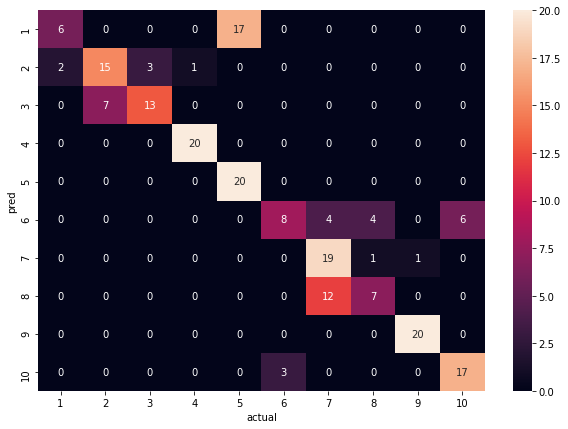

In [39]:
cm = confusion_matrix(y_trues[2], y_preds[2])
fig = plot_conf(cm)

In [41]:
fig.savefig("../conf_3.png", dpi=300)

In [42]:
from collections import Counter
Counter(y_preds[0])

Counter({2: 27, 3: 27, 5: 33, 6: 7, 10: 22, 8: 28, 9: 20, 4: 33, 7: 30})